In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, when, avg, window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Initialisation optimisée pour le cluster
spark = SparkSession.builder \
    .appName("HPC_Predictive_Maintenance") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "1") \
    .getOrCreate()

print(f"🚀 Cluster connecté. App ID: {spark.sparkContext.applicationId}")

🚀 Cluster connecté. App ID: app-20260129210805-0000


26/01/29 21:16:28 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
# Génération de 1M de lignes distribuées sur les workers
print("Génération des données de télémétrie...")
df_raw = spark.range(0, 1000000) \
    .withColumn("node_id", (rand() * 50).cast("int")) \
    .withColumn("cpu_load", rand() * 100) \
    .withColumn("temp_celsius", (col("cpu_load") * 0.8) + (rand() * 20)) \
    .withColumn("mem_usage", rand() * 64)

# Création du label "Failure" (si temp > 90 et cpu > 95)
df_data = df_raw.withColumn("label", 
    when((col("temp_celsius") > 92) & (col("cpu_load") > 95), 1).otherwise(0))

print(f"Total records: {df_data.count()}")
df_data.show(5)

Génération des données de télémétrie...
Total records: 1000000
+---+-------+------------------+------------------+-----------------+-----+
| id|node_id|          cpu_load|      temp_celsius|        mem_usage|label|
+---+-------+------------------+------------------+-----------------+-----+
|  0|     24| 82.66209691800915|  73.9644509223211| 52.8090047870239|    0|
|  1|     41| 83.85616783098567| 81.65503931728787|6.577901120180755|    0|
|  2|      7|26.813810275284013|22.516774125863932|43.12126423560292|    0|
|  3|     43| 81.57015191730201| 83.28267955126447|56.48097250488388|    0|
|  4|     35| 64.99567584416975|57.797311278696895|44.15390411001004|    0|
+---+-------+------------------+------------------+-----------------+-----+
only showing top 5 rows



In [5]:
# Sélection des features
feature_cols = ["cpu_load", "temp_celsius", "mem_usage"]

# Assemblage en vecteurs
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
df_assembled = assembler.transform(df_data)

# Standardisation (important pour les modèles de distance/gradient)
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=False)
scaler_model = scaler.fit(df_assembled)
df_final = scaler_model.transform(df_assembled).select("features", "label")

# Split Train/Test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)
print(f"Entraînement sur {train_df.count()} lignes.")

[Stage 9:>                                                          (0 + 2) / 2]

Entraînement sur 799848 lignes.


In [6]:
# Initialisation du modèle
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)

# Entraînement
print("Entraînement du modèle en cours sur le cluster...")
model = rf.fit(train_df)

# Prédictions
predictions = model.transform(test_df)
predictions.select("label", "prediction", "probability").show(5)

Entraînement du modèle en cours sur le cluster...


[Stage 29:>                                                         (0 + 1) / 1]

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.99884863657536...|
|    0|       0.0|[0.99884863657536...|
|    0|       0.0|[0.99884863657536...|
|    0|       0.0|[0.99884863657536...|
|    0|       0.0|[0.99884863657536...|
+-----+----------+--------------------+
only showing top 5 rows



[Stage 30:>                                                         (0 + 2) / 2]

Précision du modèle : 99.19%


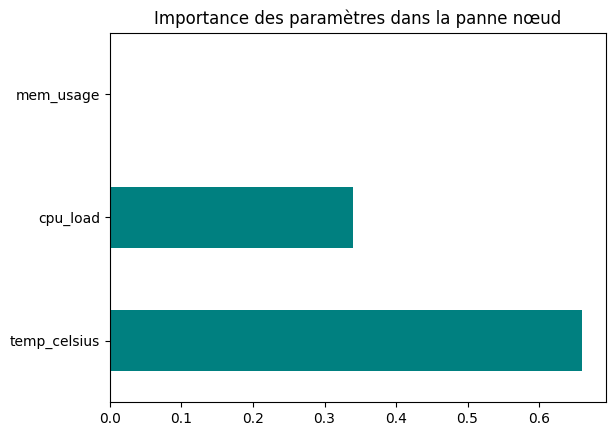

In [7]:
# Calcul de la précision (Accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Précision du modèle : {accuracy:.2%}")

# Extraction de l'importance des variables (HPC Insight)
importances = model.featureImportances.toArray()
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

# Plot rapide
feat_imp.plot(kind='barh', color='teal')
plt.title("Importance des paramètres dans la panne nœud")
plt.show()